In [1]:
import numpy as np
from scipy import stats, optimize
import pandas as pd
import seaborn as sns
from statistics import mean
import matplotlib.pyplot as plt
sns.set()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Linear Discriminant Analysis

Predict groupings in continuous data

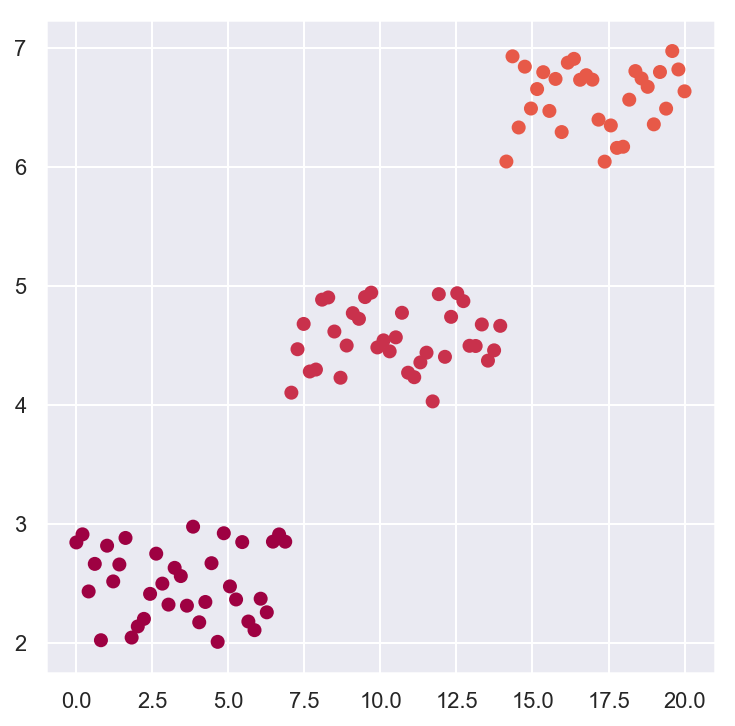

In [2]:
X = np.linspace(0, 20, 100)
def f(x):
    if x < 7:
        return 'a', 2. + np.random.random()
    elif x < 14:
        return 'b', 4 + np.random.random()
    else:
        return 'c', 6 + np.random.random()
K, Y = zip(*[f(x) for x in X])
colors = plt.get_cmap('Spectral')
categories = ['a', 'b', 'c']
plt.figure(figsize=(6,6))
plt.scatter(X, Y, c=[colors(categories.index(k)*20) for k in K])
plt.show()

LDA is like inverted ANOVA: ANOVA looks for differences in a continuous response among categories, whereas LDA infers categories using a continuous predictor.

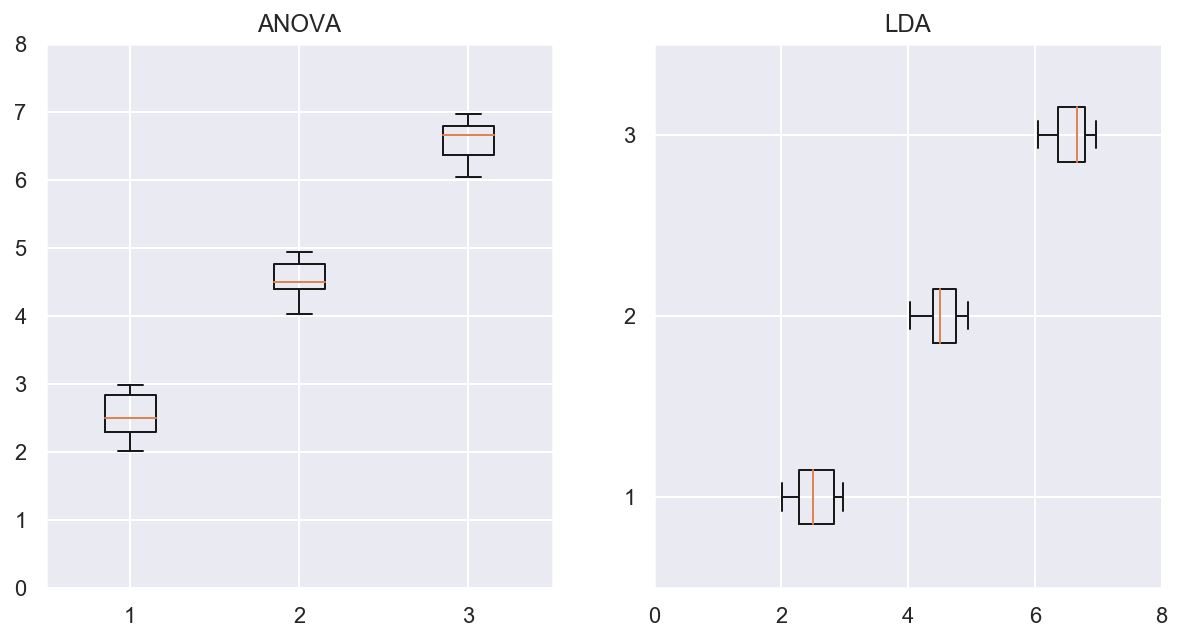

In [3]:
bycategory = [ [Y[i] for i in range(len(Y)) if K[i] == k] for k in categories ]

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.boxplot(bycategory)
plt.ylim(0, 8)
plt.title('ANOVA')

plt.subplot(122)
plt.boxplot(bycategory, 0, 'rs', 0)
plt.title('LDA')
plt.xlim(0, 8)

plt.show()

LDA assumes that the variance in each group is the same, and that the predictor(s) are normally distributed for each group. In other words, different $\mu_k$, one shared $\sigma$.

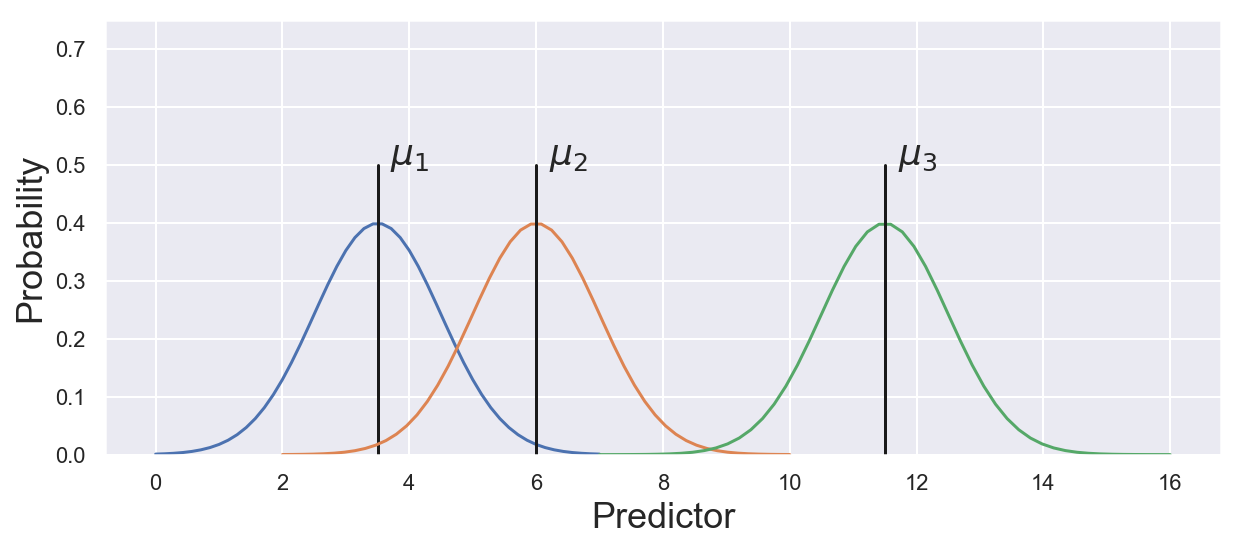

In [4]:
X = [np.linspace(0, 7, 50),
     np.linspace(2, 10, 50),
     np.linspace(7, 16, 50)]

plt.figure(figsize=(10, 4))
k = 1
for x in X:
    mu_k = x.mean()
    plt.plot(x, stats.norm.pdf(x, loc=mu_k))
    plt.plot([mu_k, mu_k], [0, 0.5], c='k')
    plt.text(mu_k + 0.2, 0.5, "$\mu_%i$" % k, size=18)
    k += 1
plt.ylim(0, 0.75)

plt.xlabel('Predictor', size=18)
plt.ylabel('Probability', size=18)
plt.show()



Recall Bayes Theorem: this allows us to "flip" the predictor and the response.

$P(A|B) = \frac{P(B|A)P(A)}{P(B|A) P(A) P(B|\bar{A}) P(\bar{A})}$

Therefore the probability of group $k$ given the continuous predictor B is:

$P(A_k|B) = \frac{P(B|A_k) P(A_k)}{\sum_{l=1}^k P(B|A_l) P(A_l)}$

The probability that a value $X=x$ came from group $Y=k$ is:

$P(Y=k|X=x) = \frac{f(x|Y=k)\pi(Y=k)}{\sum_{l=1}^k f(x|Y=l)\pi(Y=l)}$

Where $\pi(Y=k)$ is the probability of $Y=k$ regardless of $x$. This is just the relative representation of each group:

$\pi(Y=k) = \frac{n_k}{\sum_{l=1}^k n_l}$

And $f(x|Y=k) = f_k(x)$ is the PDF for group $k$:

$f_k(x) = \frac{1}{\sqrt{2\pi}\sigma}e^{\frac{-(x-\mu_k)^2}{2\sigma^2}}$

Therefore:

$P(Y=k|X=x) = \frac{\frac{1}{\sqrt{2\pi}\sigma}e^{\frac{-(x-\mu_k)^2}{2\sigma^2}}\pi(Y=k)}{\sum_{l=1}^k[ \frac{1}{\sqrt{2\pi}\sigma}e^{\frac{-(x-\mu_l)^2}{2\sigma^2}} \pi(Y=l)]}$

Assume for the sake of algebra that each $k \in K$ is represented equally: $\pi(Y=k) = \frac{1}{K}$. So:

$P(Y=k|X=x) = \frac{e^{\frac{-(x-\mu_k)^2}{2\sigma^2}}}{\sum_{l=1}^k e^{\frac{-(x-\mu_l)^2}{2\sigma^2}}}$
Discriminant function

Our prediction should be the category with the largest probability at $x$. In other words we want to choose category $k$ that maximizes $P(Y=k|X=x)$. We can therefore ignore the denomenator in the equation above. This is the same as maximizing:

$e^\frac{-(x-\mu_k)^2}{2\sigma^2}$

Since $\log$ is monotonic, this is the same as maximizing:

$\frac{-(x-\mu_k)^2}{2\sigma^2} = \frac{-(x^2 - 2x\mu_k + \mu_k)^2}{2\sigma^2}$

...which is the same as maximizing:

$\delta(x) = \frac{2x\mu_k}{2\sigma^2} - \frac{\mu_k^2}{2\sigma^2} $

$\delta(x)$ is the discriminant function. In Quadratic Discriminant Analysis, the $x$ term becomes $x^2$.

In the $k=2$ case, the boundary point $x^*$ (where our predictions flip) is found by setting:

$\delta_1(x^*) = \delta_2(x^*)$

$\frac{2x\mu_1}{2\sigma^2} - \frac{\mu_1^2}{2\sigma^2} = \frac{2x\mu_2}{2\sigma^2} - \frac{\mu_2^2}{2\sigma^2}$

...

$x^* = \frac{\mu_1 + \mu_2}{2}$

...which is precisely halfway between the two means. This makes sense, since variance is equal.

In practice, we estimate $\mu_k$ with $\hat{\mu_k} = \bar{x_1}$.


In [5]:
class LDAModel_1D(object):
    """
    Linear Discriminant Analysis with one predictor.
    
    Parameters
    ----------
    X_bound : list
        Boundary points between categories in ``K_ordered``.
    K_ordered : list
        Categories, ordered by mean.
    """
    def __init__(self, mu, sigma, K_labels):
        assert len(mu) == len(sigma)
        assert len(K_labels) == len(mu)
        
        self.K = len(K_labels)
        self.K_labels = K_labels
        self.mu = mu
        self.sigma = sigma
            
    def find_bounds(self):
        K_ordered = np.array(self.K_)[np.argsort(np.array(X_means.values()))]
        self.X_bound = []
        for i in range(1, len(K_ordered)):
            k_0, k_1 = K_ordered[i-1], K_ordered[i]
            mu_0, mu_1 = X_means[k_0], X_means[k_1]
            self.X_bound.append(mu_0 + ((mu_1 - mu_0)/2.))
                                             
    def _predict(self, x):
        for i in xrange(self.K):
            if i == 0:
                comp = lambda x: x <= self.X_bound[0]
            elif i == self.K - 1:
                comp = lambda x: x >= self.X_bound[-1]
            else:
                comp = lambda x: self.X_bound[i-1] < x < self.X_bound[i]
            if comp(x):
                return self.K_ordered[i]
            
    def predict(self, x, criterion=None):
        if criterion:
            return self.K_labels[criterion(self.posterior(x))]
        return self.K_labels[np.argmax(self.posterior(x))]
            
    def posterior(self, x):
        post_values = [stats.norm.pdf(x, loc=self.mu[i], scale=self.sigma[i]) 
                       for i in range(self.K)]
        return [pv/sum(post_values) for pv in post_values]

In [6]:
def lda(K_x, X):
    """
    Calculate the boundary points between categories.
    
    Parameters
    ----------
    K_x : list
        Known category for each observation.
    X : list
        Observations of a continuous variable.
        
    Returns
    -------
    model : :class:`.LDAModel_1D`
    """
    
    K = set(K_x)
    X_grouped = {k:[] for k in list(K)}
    for k, x in zip(K_x, X):
        X_grouped[k].append(x)
    K_labels, mu = zip(*[(k, mean(v)) for k,v in X_grouped.items()])
    sigma = [mean([np.var(v) for v in X_grouped.values()]) for i in range(len(K_labels))]

    return LDAModel_1D(mu, sigma, K_labels)

In [7]:
X = np.linspace(0, 20, 100)
def f(x):
    if x < 7:
        return 'a', 2. + np.random.random()
    elif x < 14:
        return 'b', 4 + np.random.random()
    else:
        return 'c', 6 + np.random.random()
K, Y = zip(*[f(x) for x in X])

In [8]:
model = lda(K, X)

## Iris example

In [9]:
iris = pd.read_csv('data/iris.csv')

In [10]:
iris_training = pd.concat([iris[iris.Species == 'setosa'].sample(25, random_state=8675309),
                           iris[iris.Species == 'versicolor'].sample(25, random_state=8675309),
                           iris[iris.Species == 'virginica'].sample(25, random_state=8675309)])

In [11]:
iris_test = iris.loc[iris.index.difference(iris_training.index)]

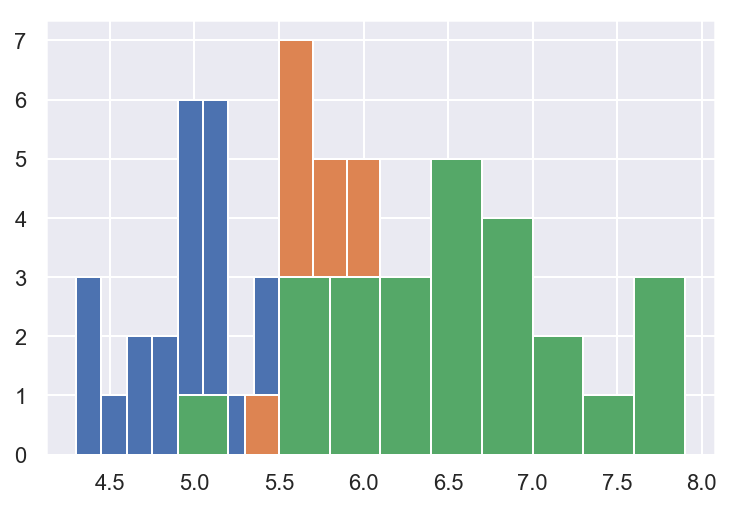

In [12]:
iris_training.groupby('Species')['Sepal.Length'].hist()
plt.show()

In [13]:
model = lda(iris_training.Species, iris_training['Sepal.Length'])

In [14]:
predictions = np.array([model.predict(x) for x in iris_test['Sepal.Length']])
truth = iris_test['Species'].values

In [15]:
results = pd.DataFrame(np.array([predictions, truth]).T, 
                       columns=['Prediction', 'Truth'])
vcounts = results.groupby('Prediction').Truth.value_counts()
vcounts_dense = np.zeros((3,3))
for i in range(model.K):
    k_i = model.K_labels[i]
    for j in range(model.K):
        k_j = model.K_labels[j]
        try:
            vcounts_dense[i,j] = vcounts[k_i][k_j]
        except KeyError:
            pass
comparison = pd.DataFrame(vcounts_dense, columns=model.K_labels)
comparison['Truth'] = model.K_labels
comparison

,versicolor,setosa,virginica,Truth
0,13.0,4.0,5.0,versicolor
1,4.0,21.0,0.0,setosa
2,8.0,0.0,20.0,virginica


In [16]:
x = stats.norm.rvs(loc=4, scale=1.3, size=200)

In [70]:
# Quadratic descriminant analysis
def qda(K_x, X):
    K = set(K_x)
    X_grouped = {k:[] for k in list(K)}
    for k, x in zip(K_x, X):
        X_grouped[k].append(x)
    
    # Maximize f to find mu and sigma
    params_k = {}
    for k, x in X_grouped.items():
        guess = (np.mean(x), np.std(x))
        
        # Variance must be greater than 0.
        constraints = {'type': 'eq', 'fun': lambda params: params[1] > 0}
        f = lambda params: np.sum(((-1.*(x - params[0])**2)/(2.*params[1]**2)) - np.log(params[1]*np.sqrt(2.*np.pi)))
        params_k[k] = optimize.minimize(lambda params: -1.*f(params), guess, constraints=constraints).x
    K_ordered = np.array(list(params_k.keys()))[np.argsort(np.array(next(zip(*params_k.values()))))]
    X_bound = []
    for i in range(1, len(K_ordered)):
        k_0, k_1 = K_ordered[i-1], K_ordered[i]
        mu_0, sigma2_0 = params_k[k_0]
        mu_1, sigma2_1 = params_k[k_1]
        delta_0 = lambda x: ((-1.*(x - mu_0)**2)/(2.*sigma2_0**2)) - np.log(sigma2_0*np.sqrt(2.*np.pi))
        delta_1 = lambda x: ((-1.*(x - mu_1)**2)/(2.*sigma2_1**2)) - np.log(sigma2_1*np.sqrt(2.*np.pi))
        bound = lambda x: np.abs(delta_0(x) - delta_1(x))
        o = optimize.minimize(bound, mu_0 + (mu_1-mu_0))
        X_bound.append(o.x)

    mu, sigma = zip(*params_k.values())
    return LDAModel_1D(mu, sigma, list(params_k.keys()))

In [71]:
qmodel = qda(iris_training.Species, iris_training['Sepal.Length'])

![](data/quick_math.png)

In [72]:
qpredictions = np.array([qmodel.predict(x) for x in iris_test['Sepal.Length']])

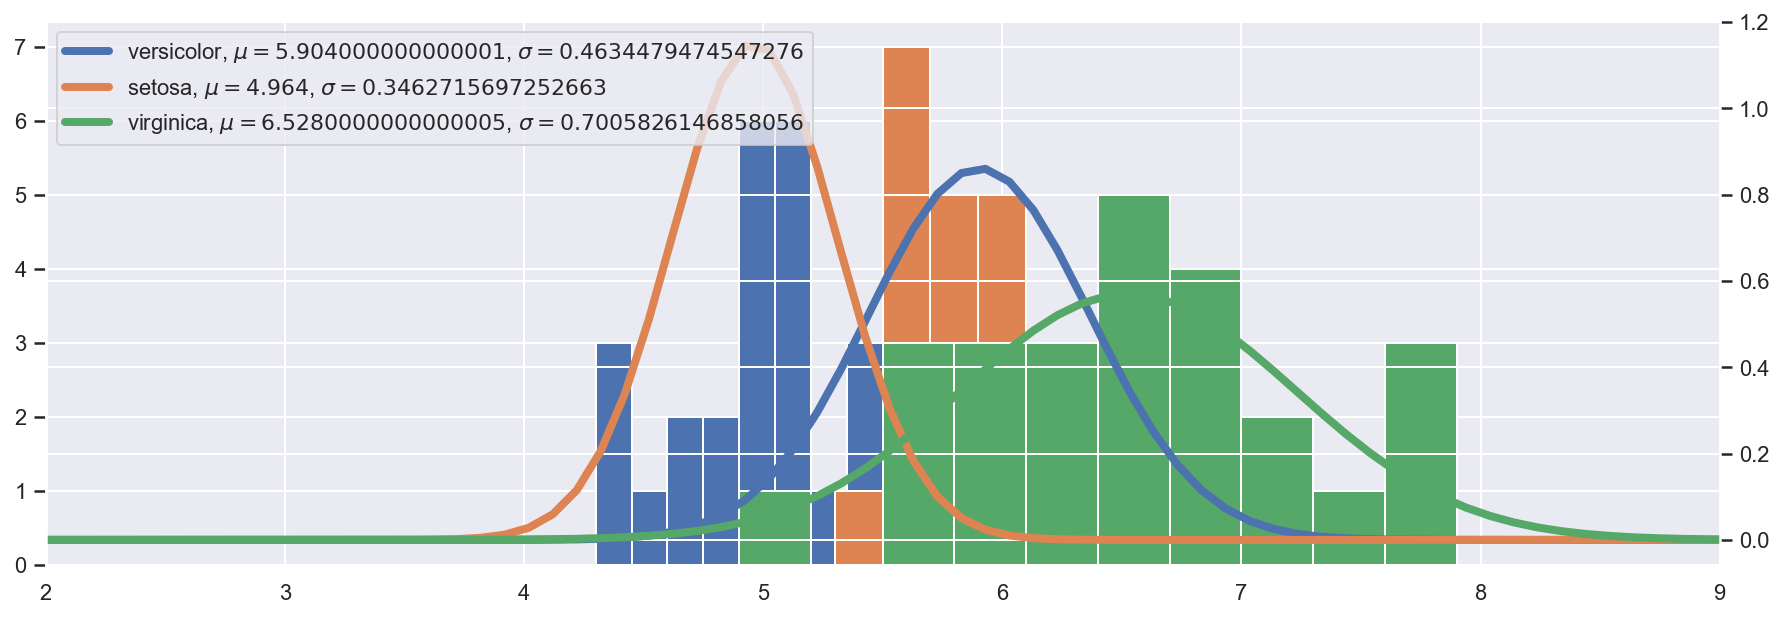

In [73]:
plt.figure(figsize=(15, 5))
X_ = np.linspace(0, 20, 200)
iris_training.groupby('Species')['Sepal.Length'].hist()
# iris_test.groupby('Species')['Sepal.Length'].hist()

ax = plt.gca()
ax2 = ax.twinx()
for k in qmodel.K_labels:
    i = qmodel.K_labels.index(k)
    ax2.plot(X_, stats.norm.pdf(X_, loc=qmodel.mu[i], scale=qmodel.sigma[i]), 
             label='{0}, $\mu={1}$, $\sigma={2}$'.format(k, qmodel.mu[i], qmodel.sigma[i]), lw=4)


plt.legend(loc=2)
plt.xlim(2, 9)
plt.show()

In [76]:
results = pd.DataFrame(np.array([qpredictions, truth]).T, 
                       columns=['Prediction', 'Truth'])
vcounts = results.groupby('Prediction').Truth.value_counts()
vcounts_dense = np.zeros((3,3))
for i in range(qmodel.K):
    k_i = qmodel.K_labels[i]
    for j in range(qmodel.K):
        k_j = qmodel.K_labels[j]
        try:
            vcounts_dense[i,j] = vcounts[k_i][k_j]
        except KeyError:
            pass
comparison = pd.DataFrame(vcounts_dense, columns=qmodel.K_labels)
comparison['Truth'] = qmodel.K_labels
comparison

,versicolor,setosa,virginica,Truth
0,14.0,4.0,9.0,versicolor
1,4.0,21.0,0.0,setosa
2,7.0,0.0,16.0,virginica


In [81]:
c = np.array(list(zip(qpredictions, truth))).T
float((c[0] == c[1]).sum())/c.shape[1]

0.68